In [31]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)
from itertools import product
import joblib  # or use pickle
from pyswarms.single import GlobalBestPSO
import pickle

### Load the data

In [7]:
period = 140
data_normal, RF_ab, LF_ab, LH_ab, RH_ab = prepare_datasets(period, generate_data_set)
data_for_train = np.vstack((data_normal, RF_ab, LF_ab, LH_ab,RH_ab))
# RF LF LH RH 
scalers = []
slices = [(16, 20), (20, 24), (24, 28), (28, 32)]

for idx, (start, end) in enumerate(slices):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    segment = data_for_train[:, start:end]
    data_for_train[:, start:end] = scaler.fit_transform(segment)
    
    # Save the scaler
    joblib.dump(scaler, f'scaler_{idx}.save')
    scalers.append(scaler)

#### Save the data (optional)

In [59]:
np.save('./DataSet/data_for_train.npy', data_for_train)

### Prepare the dataSet

In [9]:
# Example usage
train_ad, val_ad, test_ad = generate_split(0, 50)
train_lose, val_lose, test_lose = generate_split(51, 171)

train_id =  np.concatenate((train_ad, train_lose))
val_id = np.concatenate((val_ad, val_lose))
test_id = np.concatenate((test_ad, test_lose))

np.random.seed(42) 
np.random.shuffle(train_id)
np.random.shuffle(val_id)
np.random.shuffle(test_id)

train_set, val_set, test_set = generate_data_sets(train_id, val_id, test_id, data_for_train)

### Train the net

In [54]:
# train the net
LH_best_cost, LH_best_pos = optimize_esn_with_pso(train_set, val_set, 'RH')


2025-06-05 17:53:18,974 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|30/30, best_cost=0.0379
2025-06-05 17:56:12,411 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.03786419314199339, best pos: [143.86823911   0.84743813   0.19182078   0.38219126]


### Test the net

In [55]:
esn_best, grf_predicted = train_and_predict_esn(LH_best_pos, 'RH', train_set, test_set)

In [58]:
save_esn_model(esn_best,'./Model/esn_RH.pkl')

In [57]:
LH_best_pos

array([143.86823911,   0.84743813,   0.19182078,   0.38219126])

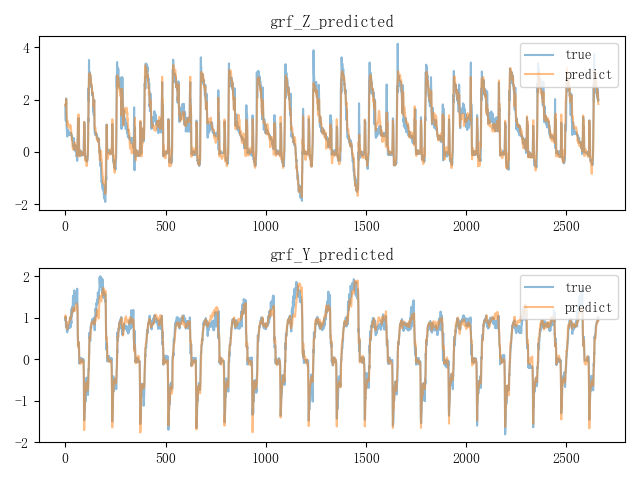

In [56]:
plt.close('all')
plt.subplot(2,1,1)
plt.plot(test_set[:,0], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,0], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Z_predicted')

plt.subplot(2,1,2)
plt.plot(test_set[:,1], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,1], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Y_predicted')
plt.tight_layout()

In [26]:
def save_esn_model(esn_model, save_path):
    """
    Save the ESN model to a file using pickle.

    Parameters:
        esn_model (ESN): The trained ESN model.
        save_path (str): Path to save the model file, e.g., "models/esn_RF.pkl".
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(esn_model, f)

In [46]:
def train_and_predict_esn(best_pos, limb_str, train_set, test_set):
    """
    Train ESN using best PSO parameters and predict GRF on test set.

    Parameters:
        best_pos (list or array): Optimized hyperparameters [res_size, sr, sparsity, leak_rate].
        limb_str (str): One of {"RF", "LF", "LH", "RH"}.
        train_set (np.ndarray): Training data.
        test_set (np.ndarray): Test data.

    Returns:
        final_esn (ESN): Trained ESN model.
        grf_predicted (np.ndarray): Predicted GRFs from the test set.
    """
    input_slices = {
        "RF": (16, 20),
        "LF": (20, 24),
        "LH": (24, 28),
        "RH": (28, 32)
    }
    target_slices = {
        "RF": (32, 34),
        "LF": (34, 36),
        "LH": (36, 38),
        "RH": (38, 40)
    }

    if limb_str not in input_slices or limb_str not in target_slices:
        raise ValueError(f"Invalid limb_str '{limb_str}'. Must be one of: {list(input_slices.keys())}")

    # Unpack best parameters
    best_res_size = int(best_pos[0])
    best_sr = best_pos[1]
    best_sp = best_pos[2]
    best_lk = best_pos[3]

    # Get slices
    in_start, in_end = input_slices[limb_str]
    out_start, out_end = target_slices[limb_str]

    # Prepare training and testing data
    train_inputs = train_set[:, in_start:in_end]
    train_targets = train_set[:, out_start:out_end]
    test_inputs = test_set[:, in_start:in_end]
    test_targets = test_set[:, out_start:out_end]

    # Initialize and train ESN
    final_esn = ESN(
        input_size=4,
        reservoir_size=best_res_size,
        output_size=2,
        spectral_radius=best_sr,
        sparsity=best_sp,
        leak_rate=best_lk,
        seed=42
    )
    final_esn.fit(train_inputs, train_targets)

    # Predict
    grf_predicted = final_esn.predict(test_inputs)

    return final_esn, grf_predicted

In [47]:
def optimize_esn_with_pso(train_set, val_set, limb_str):
    """
    Optimize ESN hyperparameters using PSO for a specific limb.
    
    Parameters:
        train_set (np.ndarray): Training data array.
        val_set (np.ndarray): Validation data array.
        limb_str (str): Limb identifier, one of {"RF", "LF", "LH", "RH"}.
        
    Returns:
        best_cost (float): Best MSE from PSO optimization.
        best_pos (list): Best hyperparameter set [reservoir_size, sr, sparsity, leak_rate].
    """
    input_slices = {
        "RF": (16, 20),
        "LF": (20, 24),
        "LH": (24, 28),
        "RH": (28, 32)
    }
    target_slices = {
        "RF": (32, 34),
        "LF": (34, 36),
        "LH": (36, 38),
        "RH": (38, 40)
    }

    if limb_str not in input_slices or limb_str not in target_slices:
        raise ValueError(f"Invalid limb_str '{limb_str}'. Must be one of: {list(input_slices.keys())}")

    # Extract input and target slices
    in_start, in_end = input_slices[limb_str]
    out_start, out_end = target_slices[limb_str]

    train_inputs = train_set[:, in_start:in_end]
    train_targets = train_set[:, out_start:out_end]
    val_inputs = val_set[:, in_start:in_end]
    val_targets = val_set[:, out_start:out_end]

    # Define hyperparameter bounds: reservoir_size, sr, sparsity, leak_rate
    bounds = (
        [60,  0.8,  0.1, 0.3],   # min values
        [160, 0.95, 0.4, 0.9]    # max values
    )

    optimizer = GlobalBestPSO(
        n_particles=20,
        dimensions=4,
        options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
        bounds=bounds
    )

    best_cost, best_pos = optimizer.optimize(
        pso_objective_function,
        iters=30,
        train_inputs=train_inputs,
        train_targets=train_targets,
        val_inputs=val_inputs,
        val_targets=val_targets
    )

    return best_cost, best_pos

In [14]:
def pso_objective_function(particles, train_inputs, train_targets, val_inputs, val_targets):
    results = []

    for p in particles:
        reservoir_size = int(p[0])
        spectral_radius = p[1]
        sparsity = p[2]
        leak_rate = p[3]

        try:
            esn = ESN(
                input_size=4,
                reservoir_size=reservoir_size,
                output_size=2,
                spectral_radius=spectral_radius,
                sparsity=sparsity,
                leak_rate=leak_rate,
                seed=42
            )
            esn.fit(train_inputs, train_targets)
            predictions = esn.predict(val_inputs)

            alpha = 0.7
            mse1 = mean_squared_error(val_targets[:, 0], predictions[:, 0])
            mse2 = mean_squared_error(val_targets[:, 1], predictions[:, 1])
            weighted_mse = alpha * mse2 + (1 - alpha) * mse1

        except Exception as e:
            weighted_mse = 1e6  # large penalty for failed ESN

        results.append(weighted_mse)

    return np.array(results)

In [2]:
def prepare_datasets(period, generate_data_set, 
                     normal_path='data_for_train.csv',
                     rf_path='RF_limb.npy',
                     lf_path='LF_limb.npy',
                     lh_path='LH_limb.npy',
                     rh_path='RH_limb.npy'):
    """
    Load and preprocess datasets for normal and four abnormal limb conditions.

    Parameters:
        period (int): Number of time steps per sample.
        generate_data_set (function): Function to segment dataset by selected indices.
        normal_path (str): Path to normal data CSV file.
        rf_path (str): Path to RF abnormal data (.npy).
        lf_path (str): Path to LF abnormal data (.npy).
        lh_path (str): Path to LH abnormal data (.npy).
        rh_path (str): Path to RH abnormal data (.npy).

    Returns:
        data_normal, RF_ab, LF_ab, LH_ab, RH_ab (tuple of arrays)
    """

    np.random.seed(42)

    # Load data
    data_normal = np.loadtxt(normal_path, delimiter=',')
    RF_ab = np.load(rf_path)
    LF_ab = np.load(lf_path)
    LH_ab = np.load(lh_path)
    RH_ab = np.load(rh_path)[period*3:, :]  # Crop first 3 periods

    # Process normal data
    select_id_normal = np.arange(data_normal.shape[0] // period)
    np.random.shuffle(select_id_normal)
    data_normal = generate_data_set(select_id_normal, data_normal)

    # Process RF
    select_id_RF = np.arange(RF_ab.shape[0] // period)
    np.random.shuffle(select_id_RF)
    RF_ab = generate_data_set(select_id_RF[:30], RF_ab)

    # Process LF
    select_id_LF = np.arange(LF_ab.shape[0] // period)
    np.random.shuffle(select_id_LF)
    LF_ab = generate_data_set(select_id_LF[:30], LF_ab)

    # Process LH
    select_id_LH = np.arange(LH_ab.shape[0] // period)
    np.random.shuffle(select_id_LH)
    LH_ab = generate_data_set(select_id_LH[:30], LH_ab)

    # Process RH
    select_id_RH = np.arange(RH_ab.shape[0] // period)
    np.random.shuffle(select_id_RH)
    RH_ab = generate_data_set(select_id_RH[:30], RH_ab)

    return data_normal, RF_ab, LF_ab, LH_ab, RH_ab
def generate_data_set(train_id, data_for_train, period=140):
    train_set = []
    for i in train_id:
        train_set.append(data_for_train[period * i: period * (i + 1), :])
    return np.vstack(train_set)

In [3]:
def generate_split(start, end):
    # Generate the ID list from start to end (inclusive)
    ids = np.arange(start, end + 1)
    
    # Shuffle the ID list randomly
    np.random.shuffle(ids)
    
    # Calculate the split sizes
    total_size = len(ids)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size  # Remainder goes to the test set
    
    # Split the IDs
    train_set = ids[:train_size]
    val_set = ids[train_size:train_size + val_size]
    test_set = ids[train_size + val_size:]
    
    return train_set, val_set, test_set

In [4]:
def generate_data_sets(train_id, val_id, test_id, data_for_train, period=140):
    # Initialize empty lists to hold the subsets
    train_set = []
    val_set = []
    test_set = []

    # Populate train_set
    for i in train_id:
        train_set.append(data_for_train[period * i: period * (i + 1), :])

    # Populate val_set
    for i in val_id:
        val_set.append(data_for_train[period * i: period * (i + 1), :])

    # Populate test_set
    for i in test_id:
        test_set.append(data_for_train[period * i: period * (i + 1), :])

    return np.vstack(train_set), np.vstack(val_set), np.vstack(test_set)

In [5]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, 
                 spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.leak_rate = leak_rate

        # Input weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_size))

        # Reservoir weights
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(*W.shape) < sparsity
        W *= mask  # sparsify
        eigvals = np.max(np.abs(np.linalg.eigvals(W)))
        self.Wres = W * (spectral_radius / eigvals)

        # Output weights (trained later)
        self.Wout = None

        self.state = np.zeros((reservoir_size,))

    def _update_state(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.Wres, self.state)
        new_state = np.tanh(pre_activation)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state
        return self.state

    def fit(self, inputs, targets, washout=50, ridge_lambda=1e-6):
        states = []
        for u in inputs:
            state = self._update_state(u)
            states.append(state)

        states = np.array(states)
        states_washed = states[washout:]
        targets_washed = targets[washout:]

        # Add bias term
        extended_states = np.hstack([states_washed, np.ones((states_washed.shape[0], 1))])
        
        # Ridge regression
        self.Wout = np.dot(np.linalg.pinv(extended_states), targets_washed)

    def predict(self, inputs):
        outputs = []
        for u in inputs:
            state = self._update_state(u)
            extended_state = np.concatenate([state, [1]])  # Add bias
            y = np.dot(extended_state, self.Wout)
            outputs.append(y)
        return np.array(outputs)

In [6]:
def plot_leg_joints(data, joint_label='关节', title='四足机器人关节数据', save_path=None):
    """
    绘制四足机器人关节数据的2x2子图
    
    参数:
        data: numpy数组，形状为[n,16]，包含四个腿的关节数据
        joint_label: 关节标签名称 (默认: '关节')
        title: 图表标题 (默认: '四足机器人关节数据')
        save_path: 图片保存路径 (可选)，如'output.png'
    """
    # 设置中文字体为宋体
    plt.rcParams['font.sans-serif'] = ['SimSun']  # 或者使用 'STSong'
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    
    # 检查数据形状
    if data.shape[1] != 16:
        raise ValueError("输入数据的列数应为16 (4腿×4关节)")
    
    # 创建2x2的子图布局
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)

    # 定义每个腿的标签和颜色
    leg_names = ['腿1', '腿2', '腿3', '腿4']
    joint_names = [f'{joint_label}{i+1}' for i in range(4)]  # 使用输入的关节标签
    colors = ['r', 'g', 'b', 'm']  # 每种关节的颜色
    line_styles = ['-', '--', ':', '-.']  # 可选的线型

    # 绘制每个腿的数据
    for leg_idx in range(4):
        # 确定子图位置
        if leg_idx == 0:  # Leg1 -> (0,1)
            ax = axs[0, 1]
        elif leg_idx == 1:  # Leg2 -> (0,0)
            ax = axs[0, 0]
        elif leg_idx == 2:  # Leg3 -> (1,0)
            ax = axs[1, 0]
        else:  # Leg4 -> (1,1)
            ax = axs[1, 1]
        
        # 提取当前腿的数据 (4个关节)
        leg_data = data[:, leg_idx*4 : (leg_idx+1)*4]
        
        # 绘制每个关节的数据
        for joint_idx in range(4):
            ax.plot(leg_data[:, joint_idx], 
                    color=colors[joint_idx],
                    linestyle=line_styles[joint_idx],
                    linewidth=1.5,
                    label=joint_names[joint_idx])
        
        # 设置子图标题和标签
        ax.set_title(f'{leg_names[leg_idx]}{joint_label}数据')
        ax.set_xlabel('时间点')
        ax.set_ylabel(f'{joint_label}值(rad)')
        ax.legend(loc='upper right')
        # ax.grid(True, linestyle='--', alpha=0.6)

    # 调整子图间距
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # 保存或显示图形
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图表已保存至: {save_path}")
    plt.show()

In [12]:
def plot_joint_angles(joint_angles, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)"):
    """
    绘制四关节角度信号
    
    参数:
        joint_angles: 形状为(n,4)的numpy数组，包含四个关节的角度数据
        title: 图表标题 (默认: "Joint Angles")
        xlabel: x轴标签 (默认: "Time")
        ylabel: y轴标签 (默认: "Angle (degrees)")
    """
    # 检查输入数据
    if not isinstance(joint_angles, np.ndarray) or joint_angles.shape[1] != 4:
        raise ValueError("输入数据必须是形状为(n,4)的numpy数组")
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 时间轴 (假设是等间隔采样)
    time = np.arange(joint_angles.shape[0])
    
    # 为每个关节绘制曲线
    joints = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4']
    colors = ['b', 'g', 'r', 'c']  # 不同颜色区分关节
    
    for i in range(4):
        ax.plot(time, joint_angles[:, i], 
                color=colors[i], 
                label=joints[i],
                linewidth=1.5)
    
    # 添加图例和标签
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # # 添加网格
    # ax.grid(True, linestyle='--', alpha=0.6)
    
    # 自动调整布局
    plt.tight_layout()
    
    # 显示图形